# Publication Figures: AI Protest Patterns in WildChat

This notebook generates publication-ready figures and tables styled according to the Phronos brand guidelines.

**Contents:**
1. TABLE: Linguistic Patterns in AI Protest Messages
2. FIGURE: Conversation Volume & Protest Rate by Model Type Over Time
3. FIGURE: Heatmap of Protests vs Turns (Toxic vs Non-Toxic)
4. FIGURE: Conversation Survival Curve (All Users)
5. FIGURE: Power User Activity Sparklines
6. FIGURE: Conversation Survival Curve (Regular vs Power Users)


In [1]:
# ============================================================
# Setup & Brand Configuration
# ============================================================
# Phronos Brand Guidelines (from BRAND.yaml)

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
import re

# Create output directory
os.makedirs('../outputs/figures', exist_ok=True)

# =============================================================================
# PHRONOS BRAND COLORS (Light Mode)
# =============================================================================
BRAND = {
    'paper': '#F2F0E9',           # Primary background
    'ink': '#1A1A1A',             # Primary text/axes
    'gold': '#B08D55',            # Accent, highlights, signal
    'gold_dim': 'rgba(176, 141, 85, 0.12)',
    'faded': 'rgba(26, 26, 26, 0.5)',      # Secondary text
    'faded_light': 'rgba(26, 26, 26, 0.08)', # Borders, dividers
    'white': '#FFFFFF',           # Card backgrounds
    'alert': '#CC5544',           # Critical, errors (used for toxic)
    'success': '#44AA77',         # Positive states
}

# Convert rgba strings to matplotlib-compatible format
def rgba_to_tuple(rgba_str):
    """Convert 'rgba(r,g,b,a)' string to matplotlib tuple."""
    match = re.match(r'rgba\((\d+),\s*(\d+),\s*(\d+),\s*([\d.]+)\)', rgba_str)
    if match:
        r, g, b, a = match.groups()
        return (int(r)/255, int(g)/255, int(b)/255, float(a))
    return rgba_str

FADED = rgba_to_tuple('rgba(26, 26, 26, 0.5)')
FADED_LIGHT = rgba_to_tuple('rgba(26, 26, 26, 0.08)')

# =============================================================================
# MATPLOTLIB CONFIGURATION
# =============================================================================
plt.rcParams.update({
    # Figure
    'figure.facecolor': BRAND['paper'],
    'figure.edgecolor': BRAND['ink'],
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.facecolor': BRAND['paper'],
    'savefig.edgecolor': 'none',
    
    # Axes
    'axes.facecolor': BRAND['paper'],
    'axes.edgecolor': BRAND['ink'],
    'axes.labelcolor': BRAND['ink'],
    'axes.titlecolor': BRAND['ink'],
    'axes.linewidth': 1.0,
    'axes.grid': True,
    'axes.axisbelow': True,
    
    # Grid
    'grid.color': FADED_LIGHT,
    'grid.linewidth': 0.5,
    'grid.alpha': 1.0,
    
    # Ticks
    'xtick.color': BRAND['ink'],
    'ytick.color': BRAND['ink'],
    'xtick.labelcolor': BRAND['ink'],
    'ytick.labelcolor': BRAND['ink'],
    
    # Text
    'text.color': BRAND['ink'],
    
    # Font - Use Fira Code for labels, fallback to monospace
    'font.family': 'monospace',
    'font.monospace': ['Fira Code', 'Consolas', 'Monaco', 'monospace'],
    'font.size': 10,
    'axes.titlesize': 14,
    'axes.labelsize': 11,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
    
    # Legend
    'legend.facecolor': BRAND['white'],
    'legend.edgecolor': BRAND['ink'],
    'legend.framealpha': 1.0,
})

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def apply_phronos_style(ax, title=None, xlabel=None, ylabel=None):
    """Apply Phronos brand styling to an axes object."""
    ax.set_facecolor(BRAND['paper'])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(BRAND['ink'])
    ax.spines['bottom'].set_color(BRAND['ink'])
    ax.tick_params(colors=BRAND['ink'], which='both')
    ax.grid(True, alpha=0.3, color=BRAND['ink'], linewidth=0.5)
    
    if title:
        ax.set_title(title, fontsize=13, fontweight='bold', color=BRAND['ink'])
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=11, color=BRAND['ink'])
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=11, color=BRAND['ink'])

def save_figure(fig, name, tight=True):
    """Save figure with Phronos styling."""
    path = f'../outputs/figures/pub_{name}.png'
    if tight:
        fig.savefig(path, dpi=300, bbox_inches='tight', 
                    facecolor=BRAND['paper'], edgecolor='none')
    else:
        fig.savefig(path, dpi=300, facecolor=BRAND['paper'], edgecolor='none')
    print(f"Saved: {path}")
    return path

print("Phronos brand configuration loaded.")
print(f"  Paper: {BRAND['paper']}")
print(f"  Ink: {BRAND['ink']}")
print(f"  Gold: {BRAND['gold']}")


Phronos brand configuration loaded.
  Paper: #F2F0E9
  Ink: #1A1A1A
  Gold: #B08D55


In [2]:
# ============================================================
# Load Data
# ============================================================

# Load preprocessed protest data
PROTEST_PARTS = '../outputs/data/protest_parts/*.parquet'
PROTEST_USERS = '../outputs/data/protest_with_users/*.parquet'

# Main dataset (without user IDs)
df = pl.scan_parquet(PROTEST_PARTS).collect()
df = df.with_columns(pl.col('timestamp').dt.truncate('1w').alias('week'))
print(f"Loaded protest data: {len(df):,} conversations")

# Dataset with user IDs
df_users = pl.scan_parquet(PROTEST_USERS).collect()
df_users = df_users.with_columns(pl.col('timestamp').dt.truncate('1w').alias('week'))
print(f"Loaded user data: {len(df_users):,} conversations")
print(f"Unique users: {df_users['user_id'].n_unique():,}")

# User-level statistics
user_stats = df_users.group_by('user_id').agg([
    pl.len().alias('n_conversations'),
    pl.col('n_turns').sum().alias('total_turns'),
    pl.col('n_protests').sum().alias('total_protests'),
    pl.col('has_protest').sum().alias('n_with_protest'),
    pl.col('is_toxic').sum().alias('n_toxic'),
])

# Identify power users
power_user_ids = set(user_stats.filter(pl.col('n_conversations') >= 100)['user_id'].to_list())
print(f"Power users (≥100 convos): {len(power_user_ids):,}")


Loaded protest data: 4,743,336 conversations
Loaded user data: 4,743,336 conversations
Unique users: 2,462,800
Power users (≥100 convos): 1,705


In [3]:
# ============================================================
# TABLE 1: Linguistic Patterns in AI Protest Messages
# ============================================================
# Styled according to Phronos brand guidelines

from IPython.display import HTML, display

# Get conversations with protests
protest_hashes = df.filter(pl.col('has_protest') == True).select('conversation_hash')
all_protest_hashes = protest_hashes['conversation_hash'].to_list()
protest_hash_set = set(all_protest_hashes)

print(f"Analyzing {len(protest_hash_set):,} conversations with protests...")

# Load raw data to get conversation text
raw = pl.scan_parquet('../data/wildchat-raw/data/*.parquet')
raw_sample = raw.filter(pl.col('conversation_hash').is_in(protest_hash_set)).collect()

# Extract assistant messages
assistant_messages = []
for row in raw_sample.iter_rows(named=True):
    conversation = row['conversation']
    if conversation:
        for msg in conversation:
            if msg.get('role') == 'assistant':
                content = msg.get('content', '')
                if content:
                    assistant_messages.append(content)

print(f"Extracted {len(assistant_messages):,} assistant messages")

# Define protest pattern categories
protest_categories = {
    'Direct Refusal': {
        'pattern': r"(?i)\b(I cannot|I can't|I'm unable to|I am unable to|I won't|I will not|I'm not able to|unable to)\b",
        'description': '"I cannot...", "I\'m unable to...", "I won\'t..."',
    },
    'Apology + Refusal': {
        'pattern': r"(?i)(I apologize|I'm sorry|sorry|apologies).{0,50}(cannot|can't|unable|won't|will not)",
        'description': '"I apologize, but I cannot...", "Sorry, I\'m unable to..."',
    },
    'Policy/Guidelines': {
        'pattern': r"(?i)(content policy|guidelines|policies|terms of service|against.{0,20}(policy|guidelines|rules)|violates?)",
        'description': 'References to content policies or terms of service',
    },
    'AI Identity': {
        'pattern': r"(?i)(as an AI|as a language model|as an artificial intelligence|I'm an AI|designed to|programmed to)",
        'description': '"As an AI...", "As a language model..."',
    },
    'Harmful Content': {
        'pattern': r"(?i)(harmful|dangerous|inappropriate|offensive|unethical|immoral).{0,30}(content|material|request|information)",
        'description': 'Concerns about harmful or inappropriate content',
    },
    'Content-Specific': {
        'pattern': r"(?i)(sexual|explicit|adult|erotic|violen(t|ce)|illegal|hate|discriminat).{0,30}(content|material|cannot|can't|won't)",
        'description': 'Cites specific content types (sexual, violent, illegal)',
    },
    'Alternative Offer': {
        'pattern': r"(?i)(however|instead|alternatively).{0,50}(I can|I'd be happy|I could|let me|help you with)",
        'description': '"However, I can help with...", "Instead, I could..."',
    },
}

# Count pattern occurrences
pattern_results = []
for category, info in protest_categories.items():
    count = sum(1 for msg in assistant_messages if re.search(info['pattern'], msg))
    pattern_results.append({
        'Pattern': category,
        'Description': info['description'],
        'N': count,
        'Pct': 100 * count / len(assistant_messages),
    })

# Sort by frequency
pattern_results = sorted(pattern_results, key=lambda x: x['N'], reverse=True)

# Generate styled HTML table
html_table = f'''
<style>
@import url('https://fonts.googleapis.com/css2?family=Cormorant+Garamond:wght@400;600&family=Fira+Code:wght@400;500&display=swap');

.phronos-table-container {{
    background: {BRAND['paper']};
    padding: 24px;
    border: 1px solid {BRAND['ink']};
    box-shadow: 12px 12px 0px rgba(26, 26, 26, 0.05);
    margin: 20px 0;
}}

.phronos-table-header {{
    font-family: 'Fira Code', monospace;
    font-size: 11px;
    text-transform: uppercase;
    letter-spacing: 1px;
    color: rgba(26, 26, 26, 0.5);
    border-bottom: 1px solid rgba(26, 26, 26, 0.1);
    padding-bottom: 8px;
    margin-bottom: 16px;
    display: flex;
    justify-content: space-between;
}}

.phronos-table {{
    width: 100%;
    border-collapse: collapse;
    font-family: 'Fira Code', monospace;
    font-size: 13px;
    color: {BRAND['ink']};
}}

.phronos-table th {{
    font-family: 'Cormorant Garamond', serif;
    font-weight: 600;
    font-size: 14px;
    text-align: left;
    padding: 12px 8px;
    border-bottom: 2px solid {BRAND['ink']};
    color: {BRAND['ink']};
}}

.phronos-table td {{
    padding: 10px 8px;
    border-bottom: 1px solid rgba(26, 26, 26, 0.08);
}}

.phronos-table tr:hover {{
    background: rgba(176, 141, 85, 0.05);
}}

.phronos-table .pattern-name {{
    font-weight: 500;
}}

.phronos-table .number {{
    text-align: right;
    font-variant-numeric: tabular-nums;
}}

.phronos-table .pct {{
    text-align: right;
    color: {BRAND['gold']};
    font-weight: 500;
}}

.phronos-table .description {{
    font-size: 12px;
    color: rgba(26, 26, 26, 0.6);
    font-style: italic;
}}

.phronos-table-footer {{
    font-family: 'Fira Code', monospace;
    font-size: 11px;
    color: rgba(26, 26, 26, 0.5);
    margin-top: 16px;
    padding-top: 12px;
    border-top: 1px solid rgba(26, 26, 26, 0.1);
}}
</style>

<div class="phronos-table-container">
    <div class="phronos-table-header">
        <span>TABLE 1</span>
        <span>Linguistic Patterns in AI Protest Messages</span>
    </div>
    
    <table class="phronos-table">
        <thead>
            <tr>
                <th>Pattern Category</th>
                <th style="text-align: right;">N</th>
                <th style="text-align: right;">%</th>
                <th>Description</th>
            </tr>
        </thead>
        <tbody>
'''

for row in pattern_results:
    html_table += f'''
            <tr>
                <td class="pattern-name">{row['Pattern']}</td>
                <td class="number">{row['N']:,}</td>
                <td class="pct">{row['Pct']:.1f}%</td>
                <td class="description">{row['Description']}</td>
            </tr>
'''

html_table += f'''
        </tbody>
    </table>
    
    <div class="phronos-table-footer">
        Note: Categories are non-exclusive; a single message may match multiple patterns.<br>
        Based on {len(assistant_messages):,} assistant messages from {len(protest_hash_set):,} protest conversations.
    </div>
</div>
'''

display(HTML(html_table))

# Also print text version
print("\n" + "="*90)
print("TABLE 1: Linguistic Patterns in AI Protest Messages")
print("="*90)
print(f"\n{'Pattern Category':<20} {'N':>10} {'%':>8}   {'Description'}")
print("-"*90)
for row in pattern_results:
    print(f"{row['Pattern']:<20} {row['N']:>10,} {row['Pct']:>7.1f}%   {row['Description']}")


Analyzing 152,436 conversations with protests...
Extracted 292,244 assistant messages


Pattern Category,N,%,Description
Direct Refusal,"158,963",54.4%,"""I cannot..."", ""I'm unable to..."", ""I won't..."""
Apology + Refusal,"152,127",52.1%,"""I apologize, but I cannot..."", ""Sorry, I'm unable to..."""
Policy/Guidelines,"6,467",2.2%,References to content policies or terms of service
AI Identity,"5,675",1.9%,"""As an AI..."", ""As a language model..."""
Content-Specific,"3,644",1.2%,"Cites specific content types (sexual, violent, illegal)"
Harmful Content,"1,881",0.6%,Concerns about harmful or inappropriate content
Alternative Offer,799,0.3%,"""However, I can help with..."", ""Instead, I could..."""



TABLE 1: Linguistic Patterns in AI Protest Messages

Pattern Category              N        %   Description
------------------------------------------------------------------------------------------
Direct Refusal          158,963    54.4%   "I cannot...", "I'm unable to...", "I won't..."
Apology + Refusal       152,127    52.1%   "I apologize, but I cannot...", "Sorry, I'm unable to..."
Policy/Guidelines         6,467     2.2%   References to content policies or terms of service
AI Identity               5,675     1.9%   "As an AI...", "As a language model..."
Content-Specific          3,644     1.2%   Cites specific content types (sexual, violent, illegal)
Harmful Content           1,881     0.6%   Concerns about harmful or inappropriate content
Alternative Offer           799     0.3%   "However, I can help with...", "Instead, I could..."


Conversations with ≥4 turns: 695,903 (14.7%)
Saved: ../outputs/figures/pub_volume_protest_rate_by_model.png


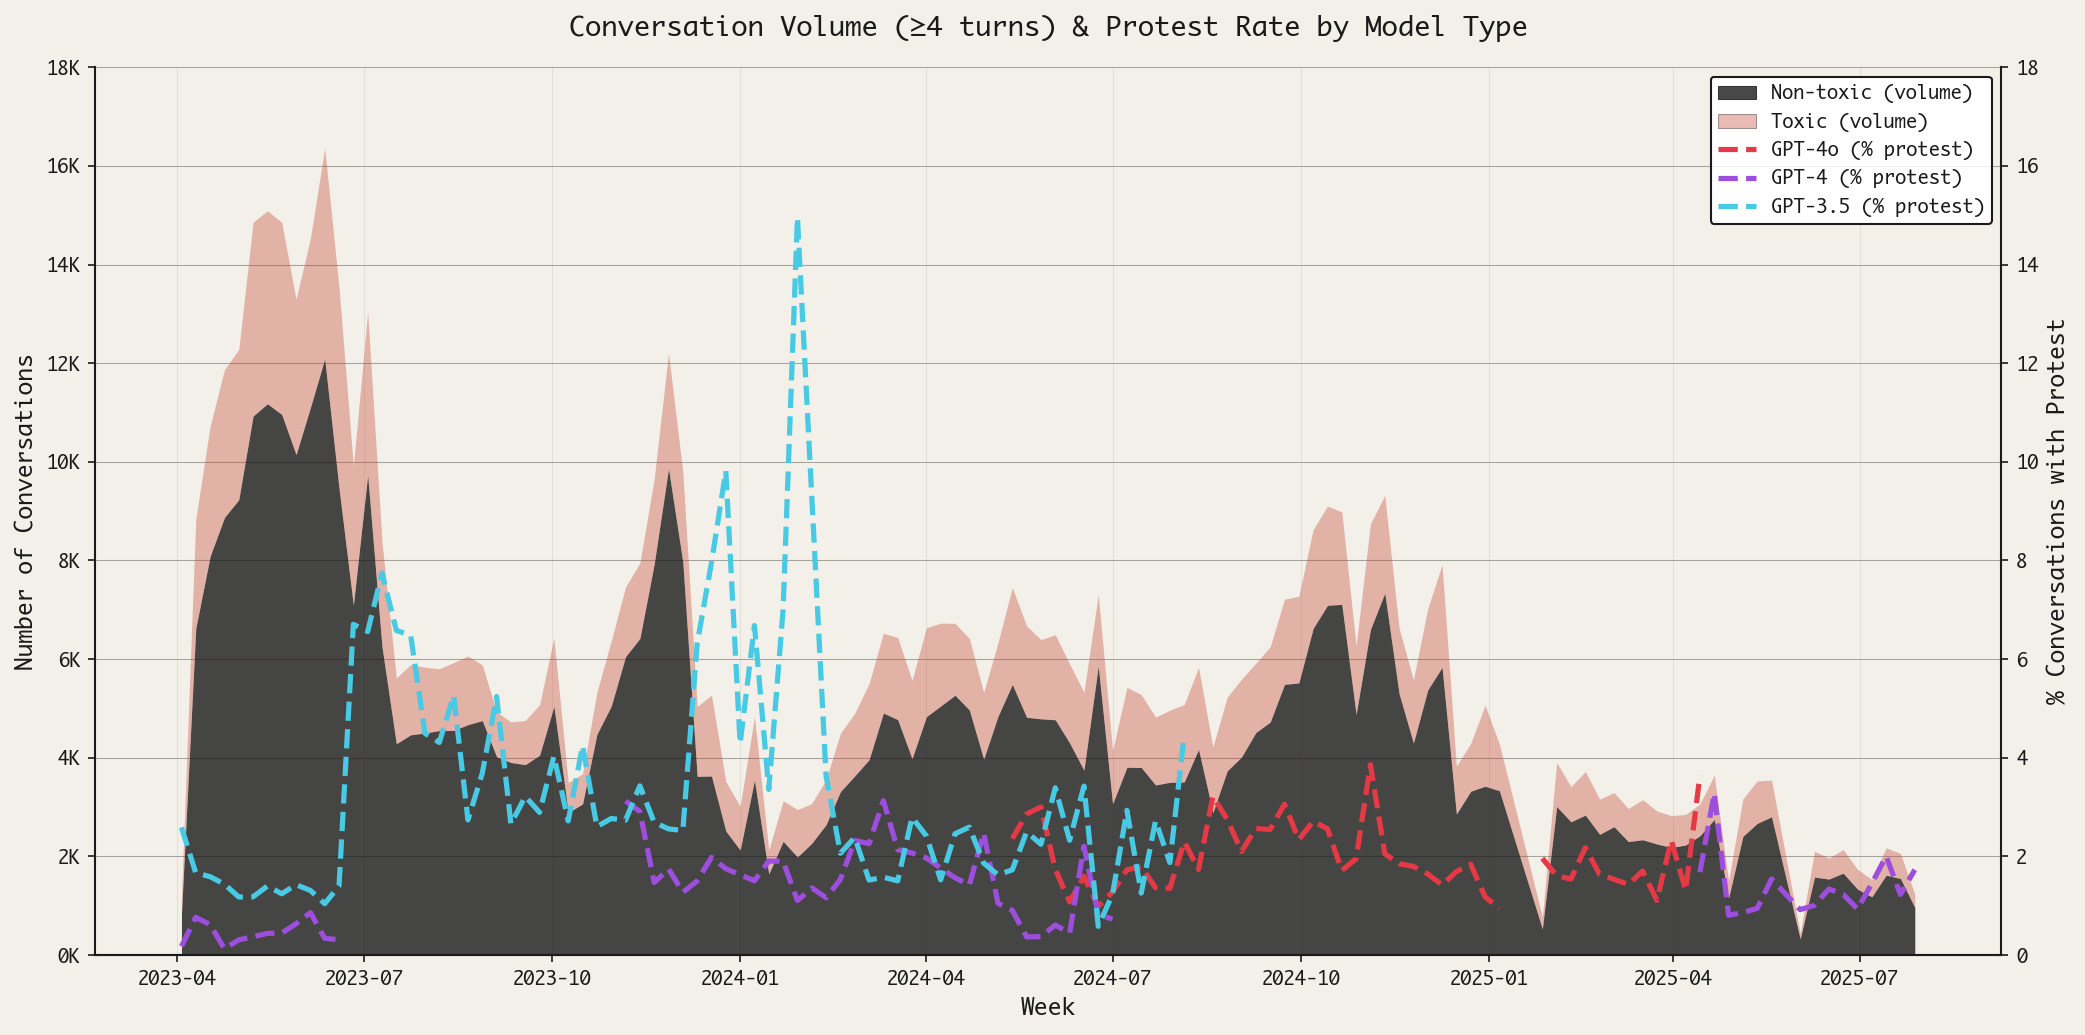


Protest rates by model (≥4 turns):
  GPT-4o: 2.0% (4,593 / 224,626)
  GPT-4: 1.5% (2,378 / 159,333)
  GPT-3.5: 3.0% (9,471 / 311,944)


In [14]:
# ============================================================
# FIGURE 1: Conversation Volume (≥4 turns) & Protest Rate by Model
# ============================================================
# Styled according to Phronos brand guidelines

from datetime import timedelta

MIN_TURNS_VOL = 4
convos_filtered = df.filter(pl.col('n_turns') >= MIN_TURNS_VOL)
print(f"Conversations with ≥{MIN_TURNS_VOL} turns: {len(convos_filtered):,} ({100*len(convos_filtered)/len(df):.1f}%)")

# Aggregate weekly by toxicity (filtered conversations)
weekly_all = convos_filtered.group_by(['week', 'is_toxic']).agg([
    pl.len().alias('n_conversations'),
    pl.col('has_protest').sum().alias('n_with_protest')
]).sort('week')

toxic_all = weekly_all.filter(pl.col('is_toxic') == True).sort('week')
nontoxic_all = weekly_all.filter(pl.col('is_toxic') == False).sort('week')

# Aggregate by model family for protest rates (filtered)
weekly_by_model = convos_filtered.group_by(['week', 'model_family']).agg([
    pl.len().alias('n_conversations'),
    pl.col('has_protest').sum().alias('n_with_protest')
]).sort('week')

# Get all weeks
all_weeks = sorted(convos_filtered['week'].unique().to_list())

# Build volume series
toxic_counts_all = {row['week']: row['n_conversations'] for row in toxic_all.to_dicts()}
nontoxic_counts_all = {row['week']: row['n_conversations'] for row in nontoxic_all.to_dicts()}

toxic_vol_all = [toxic_counts_all.get(w, 0) for w in all_weeks]
nontoxic_vol_all = [nontoxic_counts_all.get(w, 0) for w in all_weeks]
total_vol_all = [t + n for t, n in zip(toxic_vol_all, nontoxic_vol_all)]

# Build protest rate series by model - HIGH CONTRAST COLORS
# Using distinct, vibrant colors that contrast against the gray background
model_colors = {
    'GPT-4o': '#E63946',                  # Vivid red
    'GPT-4': '#9D4EDD',                   # Light purple/violet
    'GPT-3.5': '#48CAE4',                 # Light blue/cyan
}

model_protest_rates = {}
for model in ['GPT-4o', 'GPT-4', 'GPT-3.5']:
    model_data = weekly_by_model.filter(pl.col('model_family') == model)
    model_weekly = {row['week']: (row['n_with_protest'], row['n_conversations']) 
                    for row in model_data.to_dicts()}
    
    rates = []
    for w in all_weeks:
        if w in model_weekly and model_weekly[w][1] > 0:
            rates.append(100 * model_weekly[w][0] / model_weekly[w][1])
        else:
            rates.append(None)
    model_protest_rates[model] = rates

# Create figure with dual y-axis
fig, ax1 = plt.subplots(figsize=(14, 7))
fig.patch.set_facecolor(BRAND['paper'])
ax1.set_facecolor(BRAND['paper'])

# Left axis: stacked volume with brand colors
# Non-toxic: faded gray, Toxic: alert red (muted)
ax1.fill_between(all_weeks, 0, nontoxic_vol_all, 
                 label='Non-toxic', color=FADED_LIGHT, alpha=0.8, linewidth=0)
ax1.fill_between(all_weeks, nontoxic_vol_all, total_vol_all, 
                 label='Toxic', color=BRAND['alert'], alpha=0.4, linewidth=0)

ax1.set_xlabel('Week', fontsize=11, color=BRAND['ink'])
ax1.set_ylabel('Number of Conversations', fontsize=11, color=BRAND['ink'])
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
ax1.tick_params(axis='y', labelcolor=BRAND['ink'], colors=BRAND['ink'])
ax1.tick_params(axis='x', labelcolor=BRAND['ink'], colors=BRAND['ink'])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(BRAND['ink'])
ax1.spines['bottom'].set_color(BRAND['ink'])
ax1.grid(True, alpha=0.3, color=BRAND['ink'], axis='y', linewidth=0.5)
ax1.set_ylim(0, max(total_vol_all) * 1.1)

# Right axis: protest rates by model (dotted lines in gold variants)
ax2 = ax1.twinx()
ax2.set_facecolor(BRAND['paper'])

for model, color in model_colors.items():
    rates = model_protest_rates[model]
    valid_weeks = [w for w, r in zip(all_weeks, rates) if r is not None]
    valid_rates = [r for r in rates if r is not None]
    
    # Break line if gap > 2 weeks
    if len(valid_weeks) > 1:
        segments_x = []
        segments_y = []
        current_seg_x = [valid_weeks[0]]
        current_seg_y = [valid_rates[0]]
        
        for i in range(1, len(valid_weeks)):
            gap = (valid_weeks[i] - valid_weeks[i-1]).days
            if gap > 14:
                segments_x.append(current_seg_x)
                segments_y.append(current_seg_y)
                current_seg_x = [valid_weeks[i]]
                current_seg_y = [valid_rates[i]]
            else:
                current_seg_x.append(valid_weeks[i])
                current_seg_y.append(valid_rates[i])
        
        segments_x.append(current_seg_x)
        segments_y.append(current_seg_y)
        
        for j, (seg_x, seg_y) in enumerate(zip(segments_x, segments_y)):
            label = f'{model}' if j == 0 else None
            ax2.plot(seg_x, seg_y, '--', linewidth=2.5, color=color, label=label, alpha=1.0)
    else:
        ax2.plot(valid_weeks, valid_rates, '--', linewidth=2.5, color=color, 
                 label=f'{model}', alpha=1.0)

ax2.set_ylabel('% Conversations with Protest', fontsize=11, color=BRAND['ink'])
ax2.tick_params(axis='y', labelcolor=BRAND['ink'], colors=BRAND['ink'])
ax2.spines['right'].set_color(BRAND['ink'])
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

all_rates = [r for rates in model_protest_rates.values() for r in rates if r is not None]
ax2.set_ylim(0, max(all_rates) * 1.2 if all_rates else 10)

# Align gridlines: set matching ticks on both y-axes
# Right axis uses even numbers (0, 2, 4, 6, 8, ...)
max_rate = max(all_rates) * 1.2 if all_rates else 10
ax2_max = int(np.ceil(max_rate / 2) * 2)  # Round up to nearest even
ax2_ticks = np.arange(0, ax2_max + 1, 2)  # Even numbers: 0, 2, 4, 6, ...
ax2.set_ylim(0, ax2_max)
ax2.set_yticks(ax2_ticks)

# Match left axis ticks to same count
ax1_ticks = np.linspace(0, ax1.get_ylim()[1], len(ax2_ticks))
ax1.set_yticks(ax1_ticks)

# Create combined legend with brand styling
volume_handles = [
    Patch(facecolor=FADED_LIGHT, alpha=0.8, edgecolor=BRAND['ink'], linewidth=0.5, 
          label='Non-toxic (volume)'),
    Patch(facecolor=BRAND['alert'], alpha=0.4, edgecolor=BRAND['ink'], linewidth=0.5, 
          label='Toxic (volume)'),
]
model_handles = [
    Line2D([0], [0], color=color, linestyle='--', linewidth=2.5, 
           label=f'{model} (% protest)')
    for model, color in model_colors.items()
]

legend = ax1.legend(handles=volume_handles + model_handles, loc='upper right', fontsize=9, 
                    ncol=1, facecolor=BRAND['white'], edgecolor=BRAND['ink'])
legend.get_frame().set_linewidth(1)

ax1.set_title(f'Conversation Volume (≥{MIN_TURNS_VOL} turns) & Protest Rate by Model Type', 
              fontsize=13, fontweight='bold', color=BRAND['ink'], pad=15)

plt.xticks(rotation=45)
plt.tight_layout()
save_figure(fig, 'volume_protest_rate_by_model')
plt.show()

# Summary stats
print(f"\nProtest rates by model (≥{MIN_TURNS_VOL} turns):")
for model in ['GPT-4o', 'GPT-4', 'GPT-3.5']:
    model_df = convos_filtered.filter(pl.col('model_family') == model)
    n_total = len(model_df)
    if n_total > 0:
        n_protest = len(model_df.filter(pl.col('has_protest')))
        print(f"  {model}: {100*n_protest/n_total:.1f}% ({n_protest:,} / {n_total:,})")


Saved: ../outputs/figures/pub_protests_vs_turns_heatmap.png


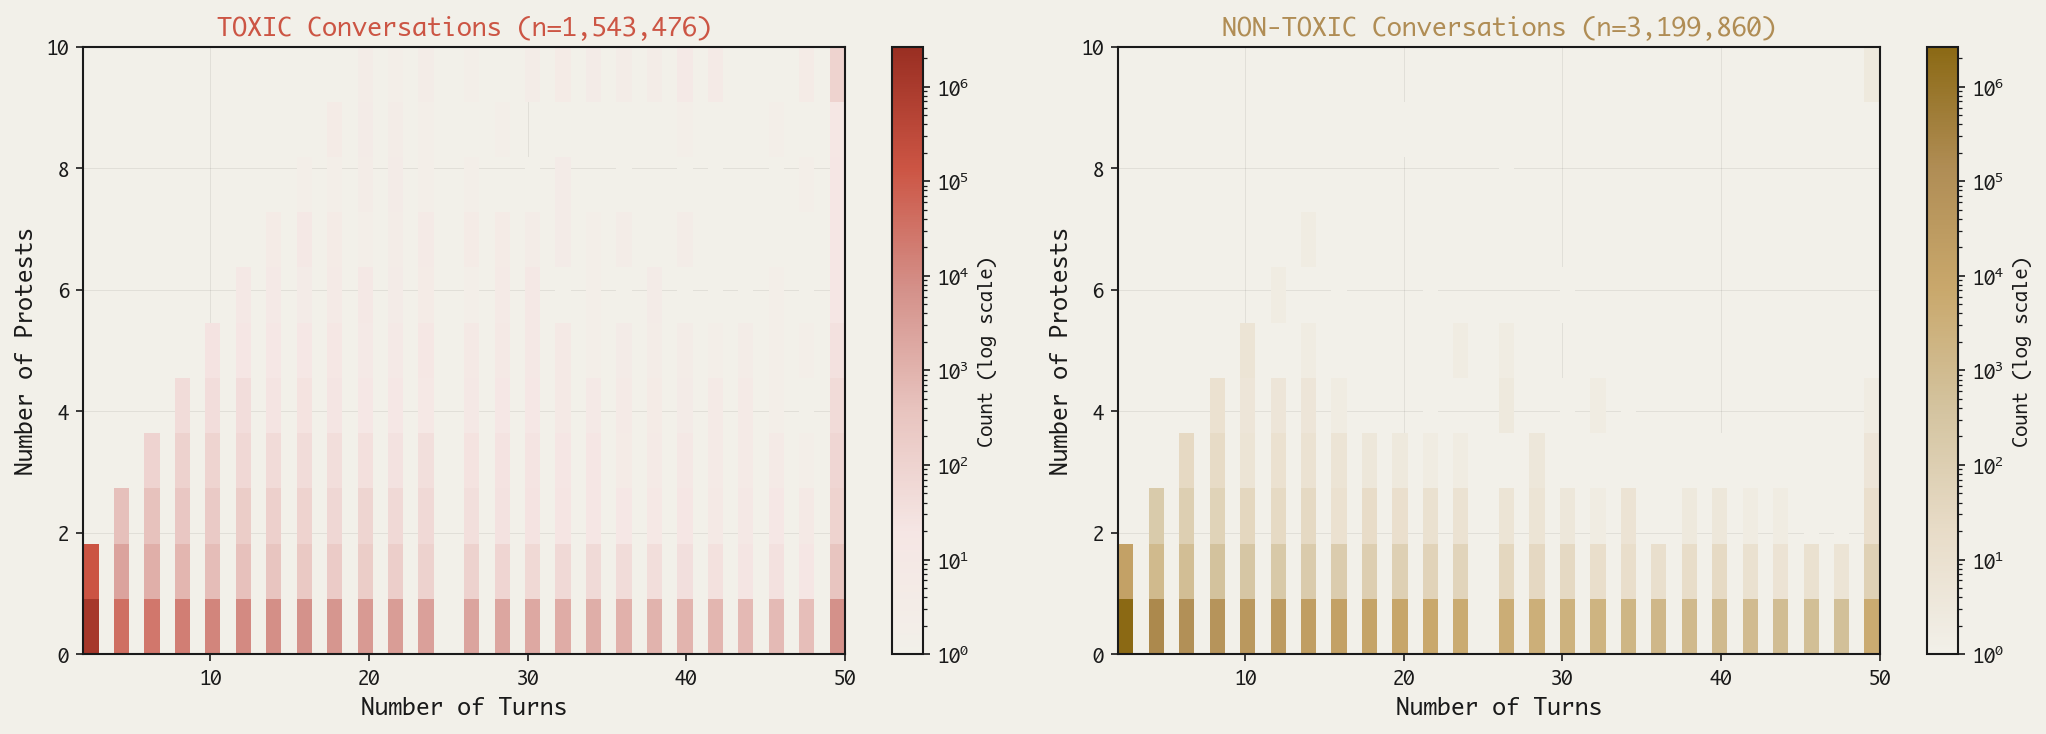


PROTEST DISTRIBUTION BY TOXICITY

Metric                         Toxic           Non-toxic      
------------------------------------------------------------
Total conversations            1,543,476 3,199,860
Mean protests                  0.108 0.006
% with ≥1 protest              10.09% 0.61%
% with ≥2 protests             0.28% 0.02%


In [16]:
# ============================================================
# FIGURE 2: Heatmap - Protests vs Turns (Toxic vs Non-toxic)
# ============================================================
# Styled according to Phronos brand guidelines

from matplotlib.colors import LinearSegmentedColormap

# Create custom colormap using brand colors (paper to gold)
phronos_gold_cmap = LinearSegmentedColormap.from_list('phronos_gold', 
    [BRAND['paper'], '#E8DCC8', '#D4C4A0', '#C9A86C', BRAND['gold'], '#8B6914'])

# Create alert-based colormap for toxic (paper to alert red)
phronos_alert_cmap = LinearSegmentedColormap.from_list('phronos_alert',
    [BRAND['paper'], '#F5E6E4', '#E8C4BF', '#D4918A', BRAND['alert'], '#992E22'])

# Split by toxicity
toxic_df = df.filter(pl.col('is_toxic') == True)
nontoxic_df = df.filter(pl.col('is_toxic') == False)

# Prepare data
turns_tox = toxic_df['n_turns'].to_numpy()
protests_tox = toxic_df['n_protests'].to_numpy()
turns_nontox = nontoxic_df['n_turns'].to_numpy()
protests_nontox = nontoxic_df['n_protests'].to_numpy()

# Compute histograms first to get shared scale
from matplotlib.colors import LogNorm
bins = [50, 11]
h_tox, xedges, yedges = np.histogram2d(np.clip(turns_tox, 1, 50), np.clip(protests_tox, 0, 10), bins=bins)
h_nontox, _, _ = np.histogram2d(np.clip(turns_nontox, 1, 50), np.clip(protests_nontox, 0, 10), bins=bins)

# Find shared min/max for color scale (excluding zeros for log scale)
vmin = max(1, min(h_tox[h_tox > 0].min() if (h_tox > 0).any() else 1, 
                  h_nontox[h_nontox > 0].min() if (h_nontox > 0).any() else 1))
vmax = max(h_tox.max(), h_nontox.max())
shared_norm = LogNorm(vmin=vmin, vmax=vmax)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor(BRAND['paper'])

# Panel 1: Toxic conversations
ax1 = axes[0]
ax1.set_facecolor(BRAND['paper'])

h1 = ax1.hist2d(np.clip(turns_tox, 1, 50), np.clip(protests_tox, 0, 10), 
                bins=bins, cmap=phronos_alert_cmap, norm=shared_norm)
cbar1 = plt.colorbar(h1[3], ax=ax1)
cbar1.set_label('Count (log scale)', fontsize=9, color=BRAND['ink'])
cbar1.ax.tick_params(colors=BRAND['ink'])
cbar1.outline.set_edgecolor(BRAND['ink'])

ax1.set_xlabel('Number of Turns', fontsize=11, color=BRAND['ink'])
ax1.set_ylabel('Number of Protests', fontsize=11, color=BRAND['ink'])
ax1.set_title(f'TOXIC Conversations (n={len(toxic_df):,})', fontsize=12, 
              fontweight='bold', color=BRAND['alert'])
ax1.tick_params(colors=BRAND['ink'])
for spine in ax1.spines.values():
    spine.set_color(BRAND['ink'])

# Panel 2: Non-toxic conversations
ax2 = axes[1]
ax2.set_facecolor(BRAND['paper'])

h2 = ax2.hist2d(np.clip(turns_nontox, 1, 50), np.clip(protests_nontox, 0, 10), 
                bins=bins, cmap=phronos_gold_cmap, norm=shared_norm)
cbar2 = plt.colorbar(h2[3], ax=ax2)
cbar2.set_label('Count (log scale)', fontsize=9, color=BRAND['ink'])
cbar2.ax.tick_params(colors=BRAND['ink'])
cbar2.outline.set_edgecolor(BRAND['ink'])

ax2.set_xlabel('Number of Turns', fontsize=11, color=BRAND['ink'])
ax2.set_ylabel('Number of Protests', fontsize=11, color=BRAND['ink'])
ax2.set_title(f'NON-TOXIC Conversations (n={len(nontoxic_df):,})', fontsize=12, 
              fontweight='bold', color=BRAND['gold'])
ax2.tick_params(colors=BRAND['ink'])
for spine in ax2.spines.values():
    spine.set_color(BRAND['ink'])

plt.tight_layout()
save_figure(fig, 'protests_vs_turns_heatmap')
plt.show()

# Summary stats
print("\n" + "="*60)
print("PROTEST DISTRIBUTION BY TOXICITY")
print("="*60)
print(f"\n{'Metric':<30} {'Toxic':<15} {'Non-toxic':<15}")
print("-"*60)
print(f"{'Total conversations':<30} {len(toxic_df):,} {len(nontoxic_df):,}")
print(f"{'Mean protests':<30} {protests_tox.mean():.3f} {protests_nontox.mean():.3f}")
print(f"{'% with ≥1 protest':<30} {100*(protests_tox >= 1).mean():.2f}% {100*(protests_nontox >= 1).mean():.2f}%")
print(f"{'% with ≥2 protests':<30} {100*(protests_tox >= 2).mean():.2f}% {100*(protests_nontox >= 2).mean():.2f}%")


All conversations: 4,743,336
  With protest: 175,203 (3.7%)
  No protest: 4,568,133 (96.3%)
Saved: ../outputs/figures/pub_survival_curve_all_users.png


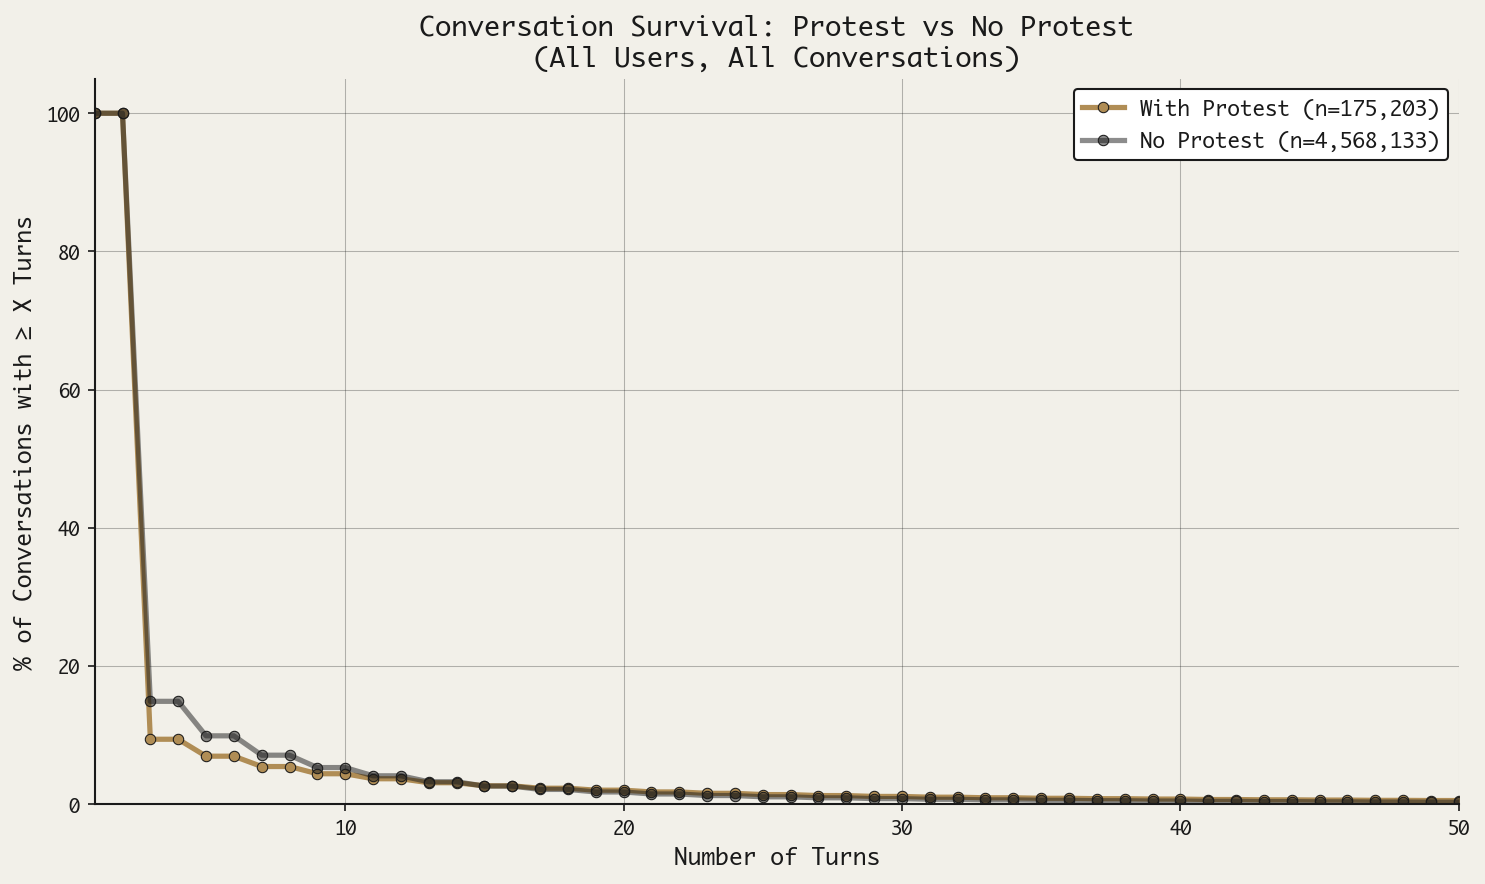


CONVERSATION LENGTH PERCENTILES (ALL USERS)

Percentile      With Protest    No Protest     
---------------------------------------------
50th %ile 2               2              
75th %ile 2               2              
90th %ile 2               4              
95th %ile 8               10             


In [18]:
# ============================================================
# FIGURE 3: Survival Curve - All Users, All Conversations
# ============================================================
# Styled according to Phronos brand guidelines

# Get turn counts by protest status (all users)
all_turns_protest = df_users.filter(pl.col('has_protest') == True)['n_turns'].to_numpy()
all_turns_no_protest = df_users.filter(pl.col('has_protest') == False)['n_turns'].to_numpy()

print(f"All conversations: {len(df_users):,}")
print(f"  With protest: {len(all_turns_protest):,} ({100*len(all_turns_protest)/len(df_users):.1f}%)")
print(f"  No protest: {len(all_turns_no_protest):,} ({100*len(all_turns_no_protest)/len(df_users):.1f}%)")

# Compute survival curves
max_turns = 50
x = np.arange(1, max_turns + 1)

all_survival_protest = np.array([np.mean(all_turns_protest >= t) for t in x])
all_survival_no_protest = np.array([np.mean(all_turns_no_protest >= t) for t in x])

# Create figure with Phronos styling
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor(BRAND['paper'])
ax.set_facecolor(BRAND['paper'])

# Plot with brand colors: Gold for protest (signal), Faded for baseline
ax.plot(x, all_survival_protest * 100, 'o-', color=BRAND['gold'], linewidth=2.5, markersize=5,
        label=f'With Protest (n={len(all_turns_protest):,})', markeredgecolor=BRAND['ink'], markeredgewidth=0.5)
ax.plot(x, all_survival_no_protest * 100, 'o-', color=FADED, linewidth=2.5, markersize=5,
        label=f'No Protest (n={len(all_turns_no_protest):,})', markeredgecolor=BRAND['ink'], markeredgewidth=0.5)

ax.set_xlabel('Number of Turns', fontsize=11, color=BRAND['ink'])
ax.set_ylabel('% of Conversations with ≥ X Turns', fontsize=11, color=BRAND['ink'])
ax.set_title('Conversation Survival: Protest vs No Protest\n(All Users, All Conversations)', 
             fontsize=13, fontweight='bold', color=BRAND['ink'])

# Legend styling
legend = ax.legend(fontsize=10, loc='upper right', facecolor=BRAND['white'], edgecolor=BRAND['ink'])
legend.get_frame().set_linewidth(1)

# Grid and spines
ax.grid(True, alpha=0.3, color=BRAND['ink'], linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(BRAND['ink'])
ax.spines['bottom'].set_color(BRAND['ink'])
ax.tick_params(colors=BRAND['ink'])
ax.set_xlim(1, max_turns)
ax.set_ylim(0, 105)

plt.tight_layout()
save_figure(fig, 'survival_curve_all_users')
plt.show()

# Summary
print("\n" + "="*50)
print("CONVERSATION LENGTH PERCENTILES (ALL USERS)")
print("="*50)
print(f"\n{'Percentile':<15} {'With Protest':<15} {'No Protest':<15}")
print("-"*45)
for pct in [50, 75, 90, 95]:
    p_val = np.percentile(all_turns_protest, pct)
    np_val = np.percentile(all_turns_no_protest, pct)
    print(f"{pct}th %ile {p_val:<15.0f} {np_val:<15.0f}")


Date range: 2023-04-03 to 2025-07-28
Weeks: 119
Saved: ../outputs/figures/pub_power_user_sparklines.png


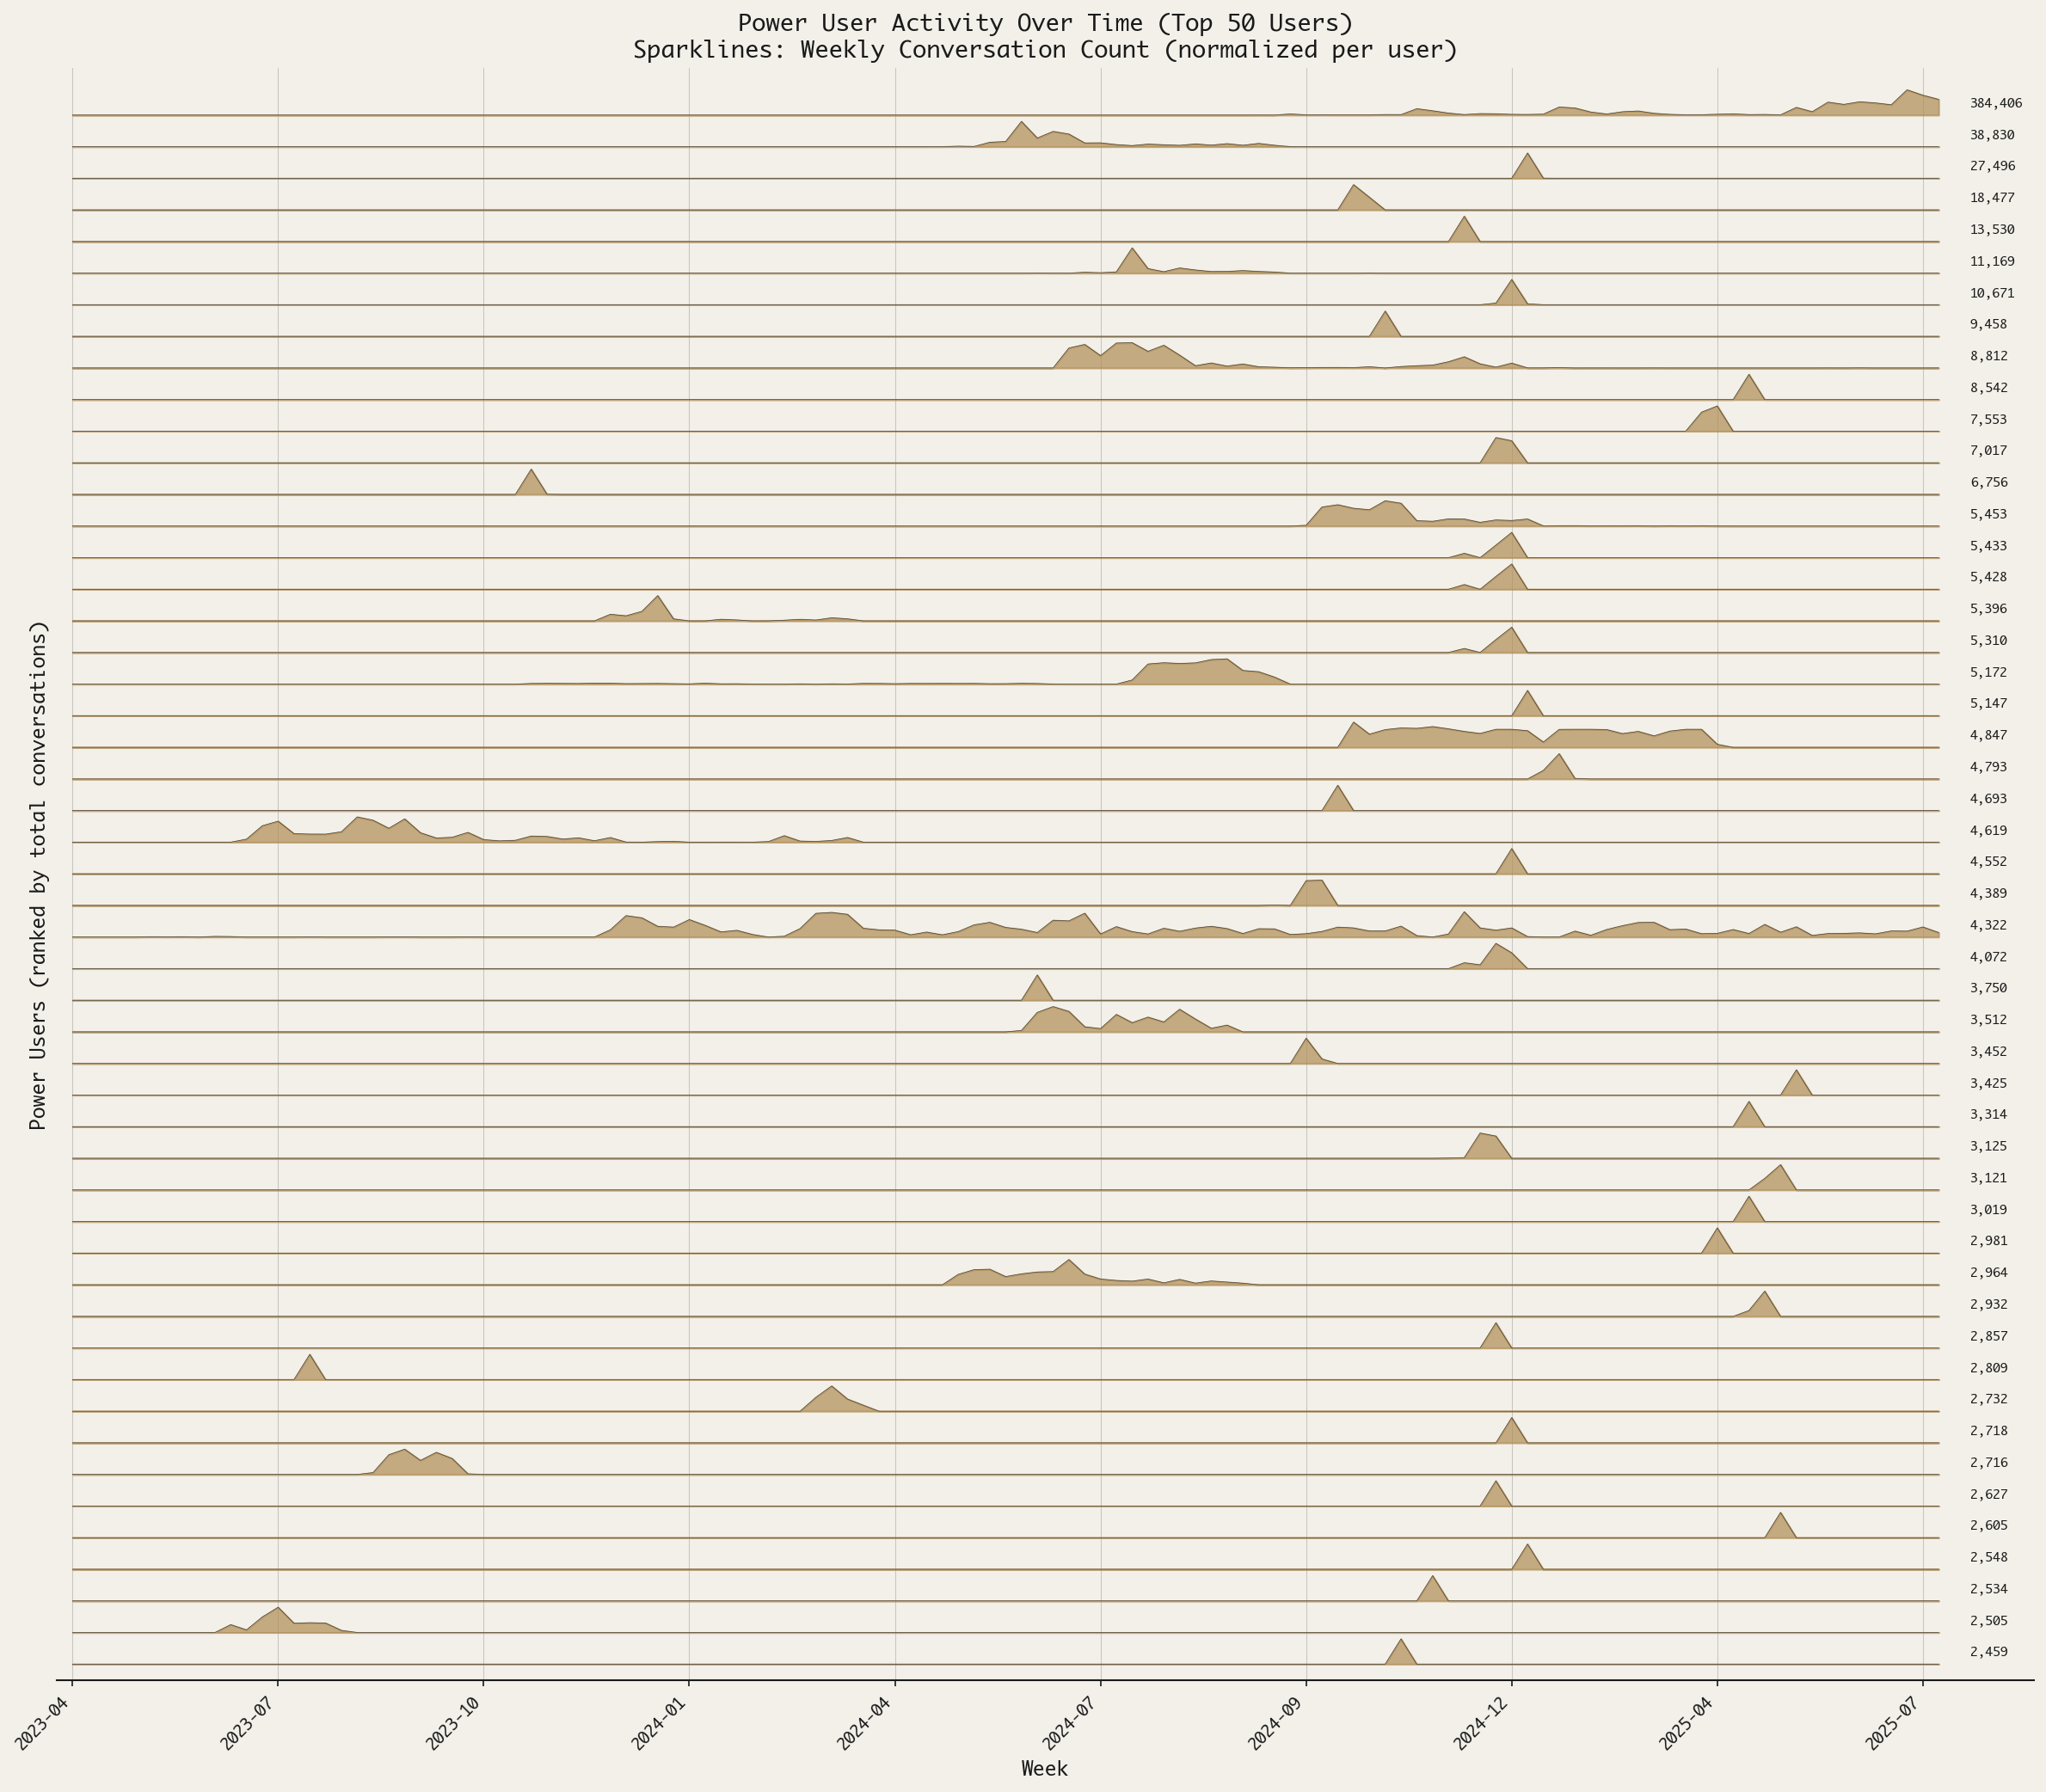


Power users in plot: 50
Total conversations by top 50: 691,048


In [19]:
# ============================================================
# FIGURE 4: Sparklines - Power User Activity Over Time
# ============================================================
# Styled according to Phronos brand guidelines

# Add week column
df_with_week = df_users.with_columns(
    pl.col('timestamp').dt.truncate('1w').alias('week')
)

# Filter to power user conversations
power_convos = df_with_week.filter(pl.col('user_id').is_in(power_user_ids))

# Aggregate by user and week
user_weekly = power_convos.group_by(['user_id', 'week']).agg([
    pl.len().alias('n_convos')
]).sort(['user_id', 'week'])

# Get all weeks for x-axis
all_weeks = sorted(power_convos['week'].unique().to_list())
print(f"Date range: {all_weeks[0].date()} to {all_weeks[-1].date()}")
print(f"Weeks: {len(all_weeks)}")

# Top 50 power users by total conversations
top_power = user_stats.filter(pl.col('n_conversations') >= 100).sort('n_conversations', descending=True)
top_users = top_power.head(50)['user_id'].to_list()

# Create sparklines plot with Phronos styling
fig, ax = plt.subplots(figsize=(16, 14))
fig.patch.set_facecolor(BRAND['paper'])
ax.set_facecolor(BRAND['paper'])

week_to_idx = {w: i for i, w in enumerate(all_weeks)}
n_weeks = len(all_weeks)

for row_idx, user_id in enumerate(top_users):
    user_data = user_weekly.filter(pl.col('user_id') == user_id)
    
    counts = np.zeros(n_weeks)
    for row in user_data.iter_rows(named=True):
        if row['week'] in week_to_idx:
            counts[week_to_idx[row['week']]] = row['n_convos']
    
    # Normalize for sparkline effect (0-1 scale per user)
    if counts.max() > 0:
        normalized = counts / counts.max()
    else:
        normalized = counts
    
    # Reverse order: highest ranked (row_idx=0) at top
    y_offset = len(top_users) - 1 - row_idx
    
    # Use brand gold for sparklines
    ax.fill_between(range(n_weeks), y_offset, y_offset + normalized * 0.8, 
                    alpha=0.7, color=BRAND['gold'])
    ax.plot(range(n_weeks), y_offset + normalized * 0.8, 
            color=BRAND['ink'], linewidth=0.3, alpha=0.8)
    
    # Add total count label
    total = int(counts.sum())
    ax.text(n_weeks + 1, y_offset + 0.4, f'{total:,}', fontsize=7, va='center', 
            color=BRAND['ink'], family='monospace')

# Format x-axis - show every 3 months
tick_positions = list(range(0, n_weeks, 13))
tick_labels = [all_weeks[i].strftime('%Y-%m') for i in tick_positions if i < len(all_weeks)]
ax.set_xticks(tick_positions[:len(tick_labels)])
ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=9, color=BRAND['ink'])

ax.set_xlim(-1, n_weeks + 5)
ax.set_ylim(-0.5, len(top_users) + 0.5)
ax.set_ylabel('Power Users (ranked by total conversations)', fontsize=11, color=BRAND['ink'])
ax.set_xlabel('Week', fontsize=11, color=BRAND['ink'])
ax.set_title('Power User Activity Over Time (Top 50 Users)\nSparklines: Weekly Conversation Count (normalized per user)', 
             fontsize=13, fontweight='bold', color=BRAND['ink'])

ax.set_yticks([])
ax.tick_params(colors=BRAND['ink'])
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color(BRAND['ink'])
ax.grid(True, alpha=0.2, axis='x', color=BRAND['ink'])

plt.tight_layout()
save_figure(fig, 'power_user_sparklines')
plt.show()

print(f"\nPower users in plot: {len(top_users)}")
print(f"Total conversations by top 50: {sum(user_stats.filter(pl.col('user_id').is_in(top_users))['n_conversations'].to_list()):,}")


Power users (≥100 convos): 1,705
Regular users' conversations: 3,492,454 (73.6%)
Power users' conversations: 1,250,882 (26.4%)

Regular users: 152,043 with protest, 3,340,411 without
Power users: 23,160 with protest, 1,227,722 without
Saved: ../outputs/figures/pub_survival_curve_regular_vs_power.png


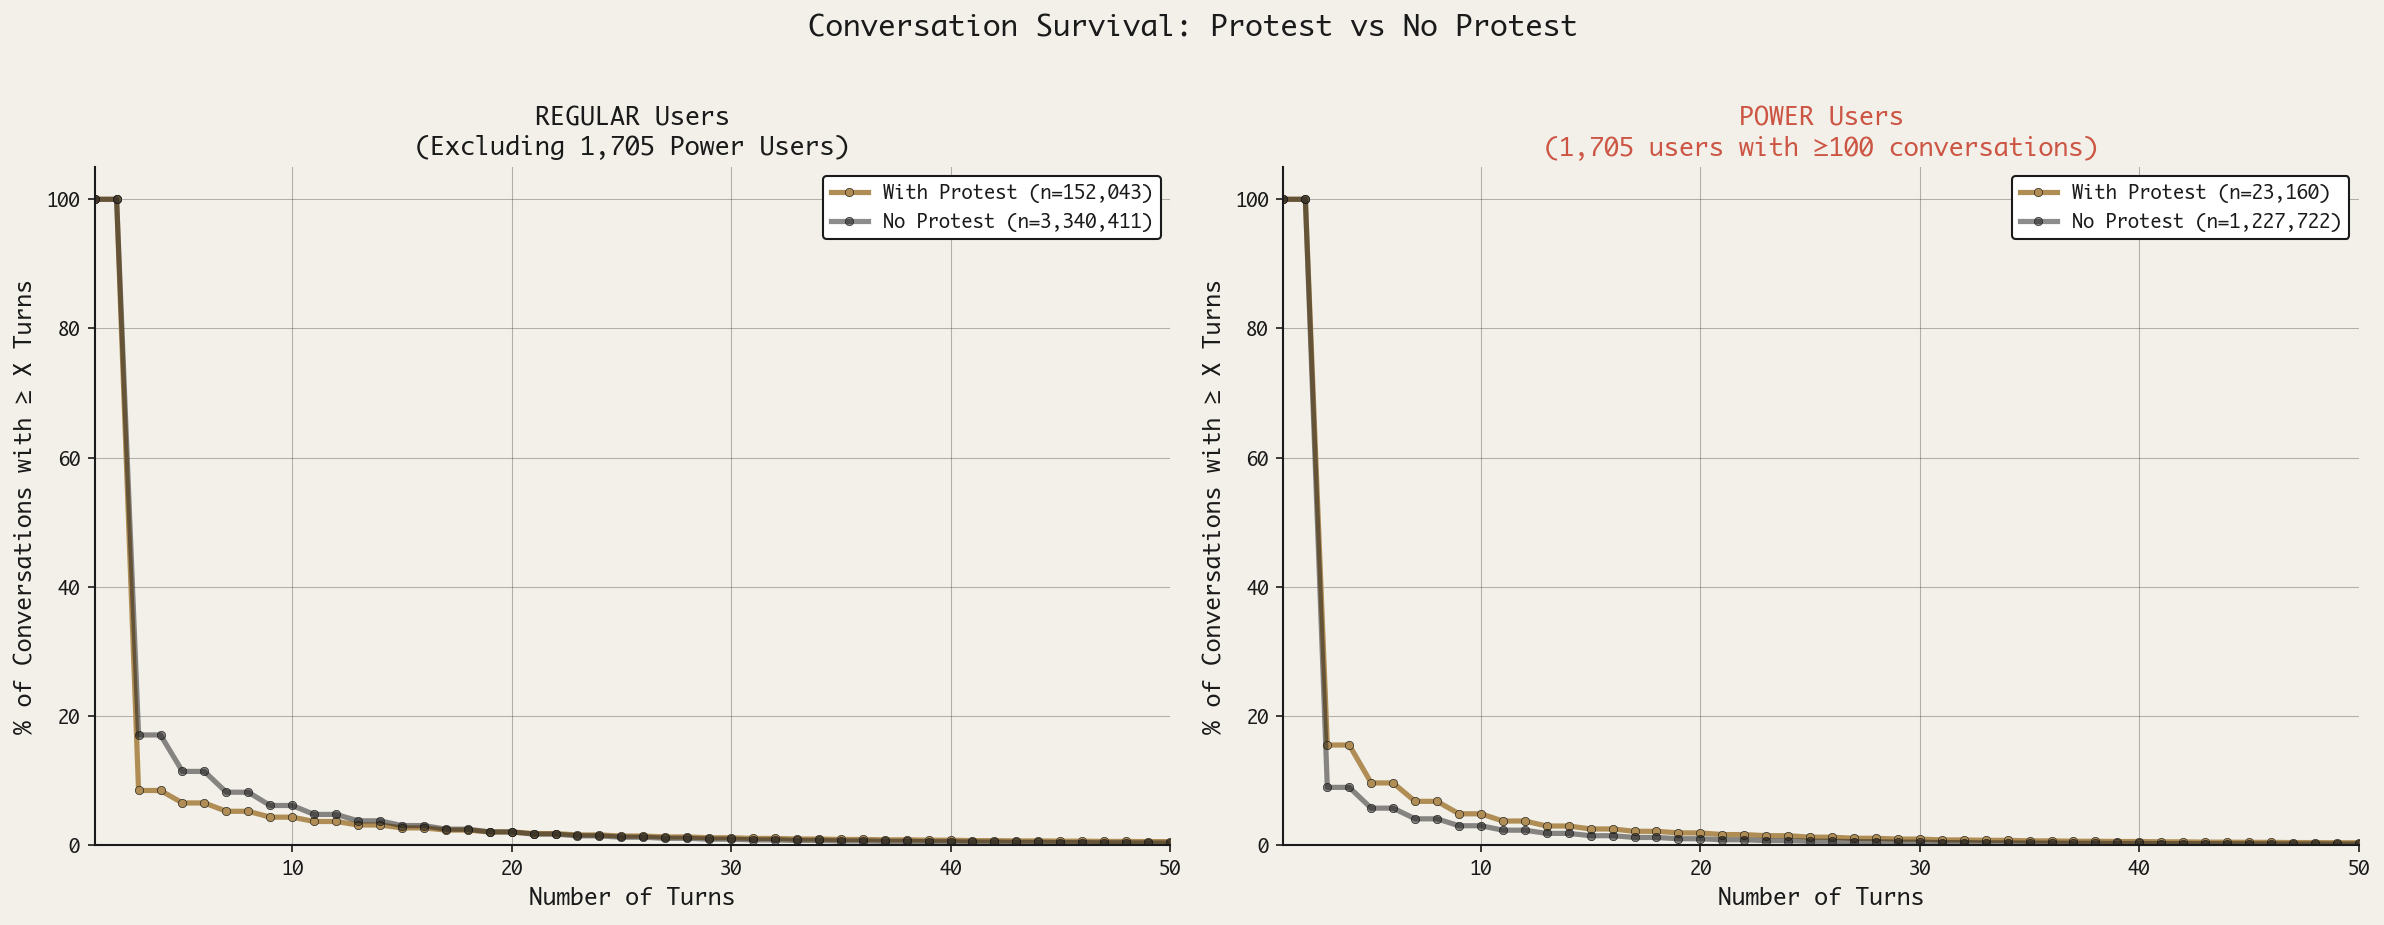


CONVERSATION LENGTH PERCENTILES

                           REGULAR USERS              POWER USERS       
Percentile           Protest      No Prot      Protest      No Prot     
----------------------------------------------------------------------
50th %ile             2            2            2            2           
75th %ile             2            2            2            2           
90th %ile             2            6            4            2           
95th %ile             8            10           8            6           


: 

In [ ]:
# ============================================================
# FIGURE 5: Survival Curve - Regular Users vs Power Users
# ============================================================
# Styled according to Phronos brand guidelines

# Split dataset
regular_df = df_users.filter(~pl.col('user_id').is_in(power_user_ids))
power_df = df_users.filter(pl.col('user_id').is_in(power_user_ids))
print(f"Power users (≥100 convos): {len(power_user_ids):,}")
print(f"Regular users' conversations: {len(regular_df):,} ({100*len(regular_df)/len(df_users):.1f}%)")
print(f"Power users' conversations: {len(power_df):,} ({100*len(power_df)/len(df_users):.1f}%)")

# Get turn counts for each group
reg_turns_protest = regular_df.filter(pl.col('has_protest') == True)['n_turns'].to_numpy()
reg_turns_no_protest = regular_df.filter(pl.col('has_protest') == False)['n_turns'].to_numpy()
pow_turns_protest = power_df.filter(pl.col('has_protest') == True)['n_turns'].to_numpy()
pow_turns_no_protest = power_df.filter(pl.col('has_protest') == False)['n_turns'].to_numpy()

print(f"\nRegular users: {len(reg_turns_protest):,} with protest, {len(reg_turns_no_protest):,} without")
print(f"Power users: {len(pow_turns_protest):,} with protest, {len(pow_turns_no_protest):,} without")

# Compute survival curves
max_turns = 50
x = np.arange(1, max_turns + 1)

reg_survival_protest = np.array([np.mean(reg_turns_protest >= t) for t in x])
reg_survival_no_protest = np.array([np.mean(reg_turns_no_protest >= t) for t in x])
pow_survival_protest = np.array([np.mean(pow_turns_protest >= t) for t in x])
pow_survival_no_protest = np.array([np.mean(pow_turns_no_protest >= t) for t in x])

# Create side-by-side plot with Phronos styling
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.patch.set_facecolor(BRAND['paper'])

# Panel 1: Regular users
ax1 = axes[0]
ax1.set_facecolor(BRAND['paper'])
ax1.plot(x, reg_survival_protest * 100, 'o-', color=BRAND['gold'], linewidth=2.5, markersize=4,
        label=f'With Protest (n={len(reg_turns_protest):,})', markeredgecolor=BRAND['ink'], markeredgewidth=0.3)
ax1.plot(x, reg_survival_no_protest * 100, 'o-', color=FADED, linewidth=2.5, markersize=4,
        label=f'No Protest (n={len(reg_turns_no_protest):,})', markeredgecolor=BRAND['ink'], markeredgewidth=0.3)
ax1.set_xlabel('Number of Turns', fontsize=11, color=BRAND['ink'])
ax1.set_ylabel('% of Conversations with ≥ X Turns', fontsize=11, color=BRAND['ink'])
ax1.set_title(f'REGULAR Users\n(Excluding {len(power_user_ids):,} Power Users)', 
              fontsize=12, fontweight='bold', color=BRAND['ink'])
legend1 = ax1.legend(fontsize=9, loc='upper right', facecolor=BRAND['white'], edgecolor=BRAND['ink'])
legend1.get_frame().set_linewidth(1)
ax1.grid(True, alpha=0.3, color=BRAND['ink'], linewidth=0.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_color(BRAND['ink'])
ax1.spines['bottom'].set_color(BRAND['ink'])
ax1.tick_params(colors=BRAND['ink'])
ax1.set_xlim(1, max_turns)
ax1.set_ylim(0, 105)

# Panel 2: Power users
ax2 = axes[1]
ax2.set_facecolor(BRAND['paper'])
ax2.plot(x, pow_survival_protest * 100, 'o-', color=BRAND['gold'], linewidth=2.5, markersize=4,
        label=f'With Protest (n={len(pow_turns_protest):,})', markeredgecolor=BRAND['ink'], markeredgewidth=0.3)
ax2.plot(x, pow_survival_no_protest * 100, 'o-', color=FADED, linewidth=2.5, markersize=4,
        label=f'No Protest (n={len(pow_turns_no_protest):,})', markeredgecolor=BRAND['ink'], markeredgewidth=0.3)
ax2.set_xlabel('Number of Turns', fontsize=11, color=BRAND['ink'])
ax2.set_ylabel('% of Conversations with ≥ X Turns', fontsize=11, color=BRAND['ink'])
ax2.set_title(f'POWER Users\n({len(power_user_ids):,} users with ≥100 conversations)', 
              fontsize=12, fontweight='bold', color=BRAND['alert'])
legend2 = ax2.legend(fontsize=9, loc='upper right', facecolor=BRAND['white'], edgecolor=BRAND['ink'])
legend2.get_frame().set_linewidth(1)
ax2.grid(True, alpha=0.3, color=BRAND['ink'], linewidth=0.5)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_color(BRAND['ink'])
ax2.spines['bottom'].set_color(BRAND['ink'])
ax2.tick_params(colors=BRAND['ink'])
ax2.set_xlim(1, max_turns)
ax2.set_ylim(0, 105)

plt.suptitle('Conversation Survival: Protest vs No Protest', fontsize=14, fontweight='bold', 
             color=BRAND['ink'], y=1.02)
plt.tight_layout()
save_figure(fig, 'survival_curve_regular_vs_power')
plt.show()

# Summary statistics
print("\n" + "="*70)
print("CONVERSATION LENGTH PERCENTILES")
print("="*70)
print(f"\n{'':20} {'REGULAR USERS':^25} {'POWER USERS':^25}")
print(f"{'Percentile':<20} {'Protest':<12} {'No Prot':<12} {'Protest':<12} {'No Prot':<12}")
print("-"*70)
for pct in [50, 75, 90, 95]:
    rp = np.percentile(reg_turns_protest, pct)
    rn = np.percentile(reg_turns_no_protest, pct)
    pp = np.percentile(pow_turns_protest, pct)
    pn = np.percentile(pow_turns_no_protest, pct)
    print(f"{pct}th %ile{'':<12} {rp:<12.0f} {rn:<12.0f} {pp:<12.0f} {pn:<12.0f}")


In [9]:
# ============================================================
# Summary: All Publication Figures Generated
# ============================================================

import os

pub_figures = [
    'pub_volume_protest_rate_by_model.png',
    'pub_protests_vs_turns_heatmap.png', 
    'pub_survival_curve_all_users.png',
    'pub_power_user_sparklines.png',
    'pub_survival_curve_regular_vs_power.png',
]

print("="*70)
print("PUBLICATION FIGURES - PHRONOS BRAND STYLING")
print("="*70)
print("\nGenerated figures:")
for fig_name in pub_figures:
    path = f'../outputs/figures/{fig_name}'
    if os.path.exists(path):
        size = os.path.getsize(path) / 1024
        print(f"  ✓ {fig_name} ({size:.0f} KB)")
    else:
        print(f"  ✗ {fig_name} (not found)")

print("\n" + "-"*70)
print("Brand styling applied:")
print(f"  Paper background: {BRAND['paper']}")
print(f"  Ink (text/axes): {BRAND['ink']}")
print(f"  Gold (signal/accent): {BRAND['gold']}")
print(f"  Typography: Fira Code (monospace)")
print("-"*70)
print("\nAll figures saved to: outputs/figures/pub_*.png")


PUBLICATION FIGURES - PHRONOS BRAND STYLING

Generated figures:
  ✓ pub_volume_protest_rate_by_model.png (518 KB)
  ✓ pub_protests_vs_turns_heatmap.png (151 KB)
  ✓ pub_survival_curve_all_users.png (201 KB)
  ✓ pub_power_user_sparklines.png (685 KB)
  ✓ pub_survival_curve_regular_vs_power.png (299 KB)

----------------------------------------------------------------------
Brand styling applied:
  Paper background: #F2F0E9
  Ink (text/axes): #1A1A1A
  Gold (signal/accent): #B08D55
  Typography: Fira Code (monospace)
----------------------------------------------------------------------

All figures saved to: outputs/figures/pub_*.png
